#      IBM HR Analytics Employee Attrition & Performance

In [33]:
#Importing all the libraries used in the code

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib notebook
%matplotlib inline
from sklearn import linear_model,neighbors
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split  
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.metrics import f1_score, accuracy_score
from sklearn.metrics import confusion_matrix
import warnings
warnings.filterwarnings('ignore')

In [8]:
#lOADING THE DATA USING PANDAS DATAFRAME

df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df = df.drop(["EmployeeCount", "StandardHours",'Over18','EmployeeNumber'], axis=1)   
#We removed these variables from the data beforehand as they were single value variables without
#any variation for all the employees, hence unimportant for predicting employee attrition.

df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EnvironmentSatisfaction,Gender,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,2,Female,...,3,1,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,3,Male,...,4,4,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,4,Male,...,3,2,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,4,Female,...,3,3,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,Male,...,3,4,1,6,3,3,2,2,2,2


In [9]:
#To check if there are any missing values in this data
df.isnull().sum()     

Age                         0
Attrition                   0
BusinessTravel              0
DailyRate                   0
Department                  0
DistanceFromHome            0
Education                   0
EducationField              0
EnvironmentSatisfaction     0
Gender                      0
HourlyRate                  0
JobInvolvement              0
JobLevel                    0
JobRole                     0
JobSatisfaction             0
MaritalStatus               0
MonthlyIncome               0
MonthlyRate                 0
NumCompaniesWorked          0
OverTime                    0
PercentSalaryHike           0
PerformanceRating           0
RelationshipSatisfaction    0
StockOptionLevel            0
TotalWorkingYears           0
TrainingTimesLastYear       0
WorkLifeBalance             0
YearsAtCompany              0
YearsInCurrentRole          0
YearsSinceLastPromotion     0
YearsWithCurrManager        0
dtype: int64

In [10]:
#To directly convert Categorical data to Numerical data

df['BusinessTravel'] =df['BusinessTravel'].astype('category').cat.codes   
df['Department'] =df['Department'].astype('category').cat.codes 
df['Gender'] =df['Gender'].astype('category').cat.codes       
df['JobRole'] =df['JobRole'].astype('category').cat.codes       
df['MaritalStatus'] =df['MaritalStatus'].astype('category').cat.codes   
df['OverTime'] =df['OverTime'].astype('category').cat.codes         
df['EducationField'] =df['EducationField'].astype('category').cat.codes  

In [11]:
#Function to generate frequencies of Attrition for each categorical data

dat1 = df.sort_values(by=['Attrition'])   #sort the data wrt Attrition column
for i in range(dat1.shape[0]):
    if dat1['Attrition'].values[i] == 'Yes':
        a = i           #row where data needs to be splitted
        break
        
dat2 = np.split(dat1,[a],axis=0)   #splitting of data into 'Yes' and 'No' wrt Attrition

dat_n = dat2[0]              #Attrition 'Yes' data
dat_y = dat2[1]              #Attrition 'No' data

def cate(data,B):           #function to generate frequency data of categorical data
	dat_A = data.sort_values(by=[B])
	L = []
	L1 = []
	c = 0
	for i in range(dat_A.shape[0]):
		if dat_A[B].values[i] not in L:
			L.append(dat_A[B].values[i]) 
			L1.append(i)
	L1.append(dat_A.shape[0])
	for j in range(len(L1)-1):
		L1[j] = (L1[j+1] - L1[j])#/data.shape[0]   #divide by data.shape[0] for getting normalised frequencies
	L1.remove(L1[len(L1)-1])
	return L1,L            #L gives categories and L1 gives frequencies

In [12]:
#Confidence interval values for each type of categorical data wrt attrition using Chi square statistic.

categ = ['BusinessTravel', 'Department', 'Education', 'EducationField',
       'EnvironmentSatisfaction', 'Gender', 'JobInvolvement', 'JobLevel', 'JobRole',
       'JobSatisfaction', 'MaritalStatus', 'OverTime', 'PerformanceRating', 'RelationshipSatisfaction',
       'StockOptionLevel', 'WorkLifeBalance']

x2 = []
for j in categ:
    W,L= cate(dat_y,j)         #frequencies and categories for Attrition 'Yes' data
    W1,L1= cate(dat_n,j)       #frequencies and categories for Attrition 'No' data
    a = W[0]
    b = W1[0]
    A = np.array([[a,b]])
    for i in range(1,len(L)):
        L3 = []
        L3.append(W[i])
        L3.append(W1[i])
        L3 = [L3]
        A = np.concatenate((A,L3))
    x1 = stats.chi2_contingency(A)
    x2.append(j+' = '+str(1 - x1[1]))
x2

['BusinessTravel = 0.9999943913855236',
 'Department = 0.9954743934255204',
 'Education = 0.45447466234340506',
 'EducationField = 0.9932260198609748',
 'EnvironmentSatisfaction = 0.9999487653109371',
 'Gender = 0.7094275509710914',
 'JobInvolvement = 0.9999971368193633',
 'JobLevel = 0.9999999999999933',
 'JobRole = 0.9999999999999972',
 'JobSatisfaction = 0.9994436995489613',
 'MaritalStatus = 0.9999999999054449',
 'OverTime = 1.0',
 'PerformanceRating = 0.009925453406542384',
 'RelationshipSatisfaction = 0.8450275562894736',
 'StockOptionLevel = 0.999999999999562',
 'WorkLifeBalance = 0.9990274301154651']

In [13]:
#Confidence interval values for each type of numerical data wrt attrition using t statistic.

categ1 = ['Age','DailyRate','DistanceFromHome','HourlyRate','MonthlyIncome','MonthlyRate','NumCompaniesWorked',
          'PercentSalaryHike','TotalWorkingYears','TrainingTimesLastYear','YearsAtCompany',
         'YearsInCurrentRole','YearsSinceLastPromotion','YearsWithCurrManager']
y4 = []
for i in categ1:
    y1 = dat_y[i].values
    y2 = dat_n[i].values
    y3 = stats.ttest_ind(y1,y2)
    y4.append(i+' = '+str(1-y3[1]))
y4

['Age = 0.9999999991643692',
 'DailyRate = 0.9701418393397351',
 'DistanceFromHome = 0.9972069399197866',
 'HourlyRate = 0.20686523100557574',
 'MonthlyIncome = 0.9999999992852636',
 'MonthlyRate = 0.43887640177569853',
 'NumCompaniesWorked = 0.9044747379434805',
 'PercentSalaryHike = 0.39438717611062435',
 'TotalWorkingYears = 0.9999999999593813',
 'TrainingTimesLastYear = 0.9774215002627987',
 'YearsAtCompany = 0.999999768112839',
 'YearsInCurrentRole = 0.9999999993996814',
 'YearsSinceLastPromotion = 0.7942100408375063',
 'YearsWithCurrManager = 0.9999999982630132']

The above statistical analysis suggests that we can say with confidence interval >=95% that HourlyRate, MonthlyRate,
PercentSalaryHike and YearsSinceLastPromotion are not significantly corresponding with attrition data.

# CORRELATION HEATMAP

<IPython.core.display.Javascript object>


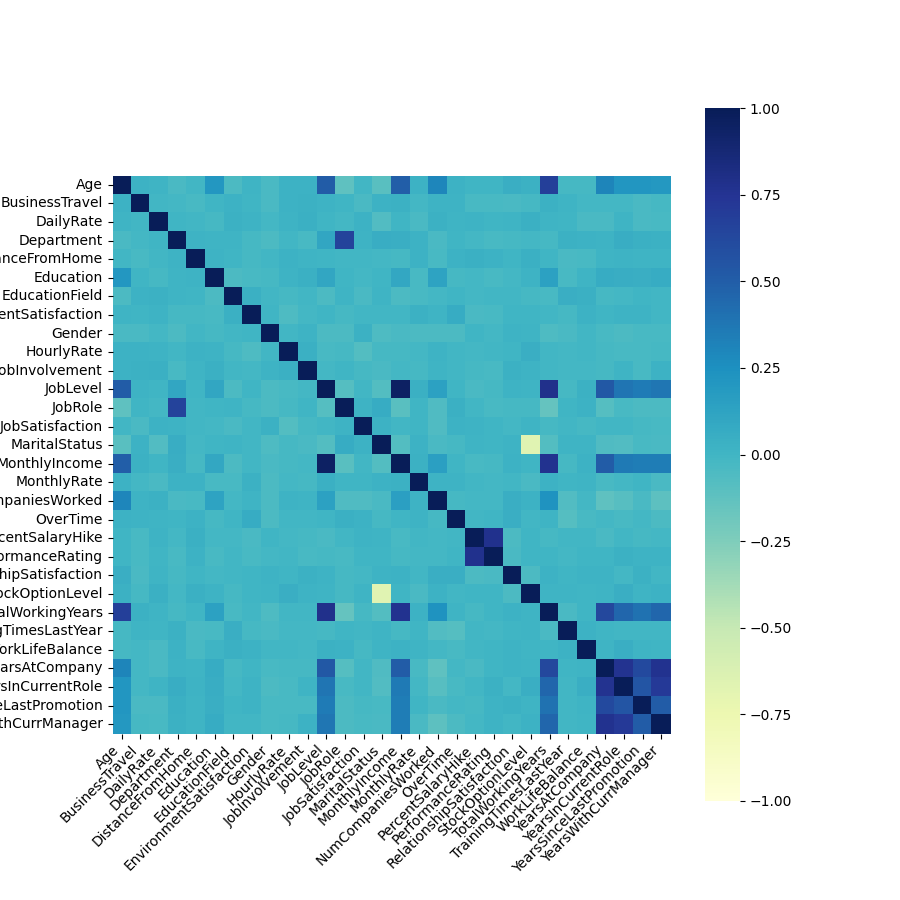

In [14]:
# Correlation Heatmap to check if the variables are correlated and if they are, we would avoid those in model building process.

plt.figure(figsize=(9,9))
cor = df.corr()

ax = sns.heatmap(cor, vmin=-1, vmax=1, center=0,cmap='YlGnBu',square=True)
ax.set_xticklabels(ax.get_xticklabels(),rotation=45,horizontalalignment='right')
plt.show()

Using the correlation heatmap analysis, we found certain variables which were strongly correlated(i.e correlation value > 0.7) with each other and hence dropped one of them depending upon which one had the weaker chi square or t statistic.

The following were the strong correlations that we found in this data.
1. Monthly income,Job level and total working years
2. YearsinCurrentRole and YearsWithCurrManager

<IPython.core.display.Javascript object>


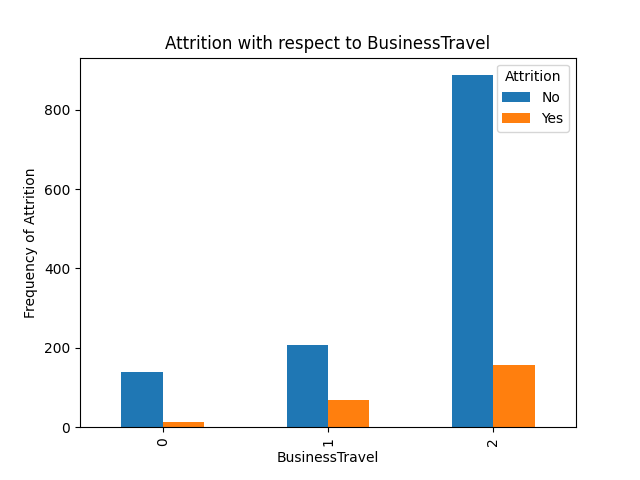

<IPython.core.display.Javascript object>


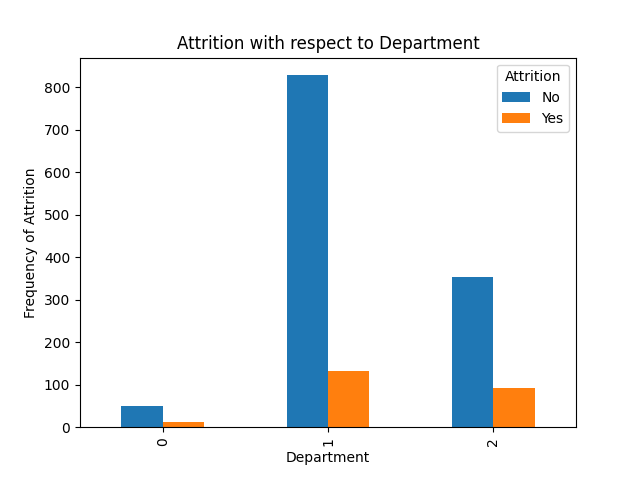

<IPython.core.display.Javascript object>


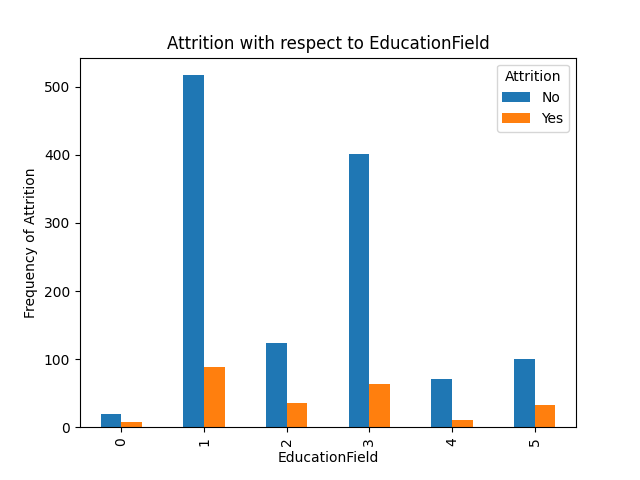

<IPython.core.display.Javascript object>


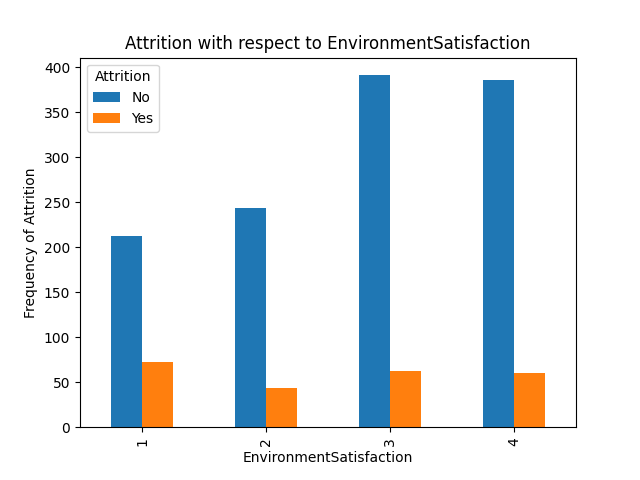

<IPython.core.display.Javascript object>


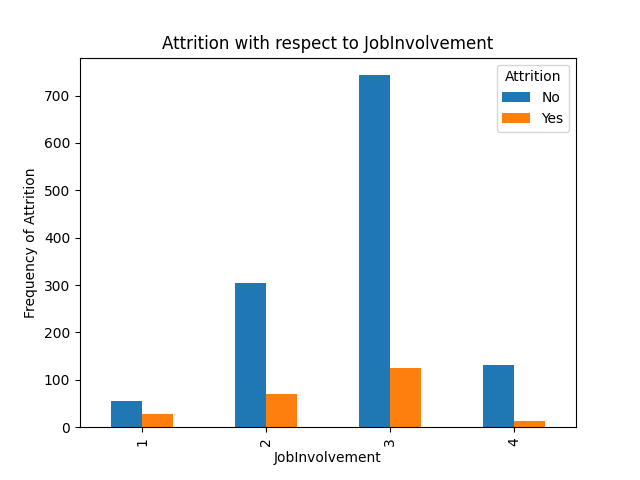

<IPython.core.display.Javascript object>


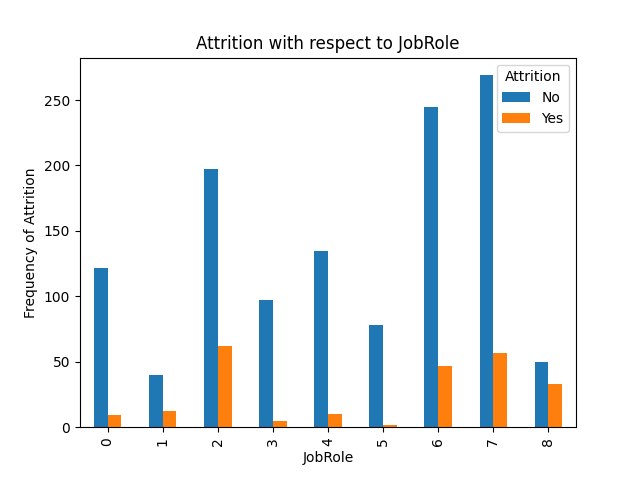

<IPython.core.display.Javascript object>


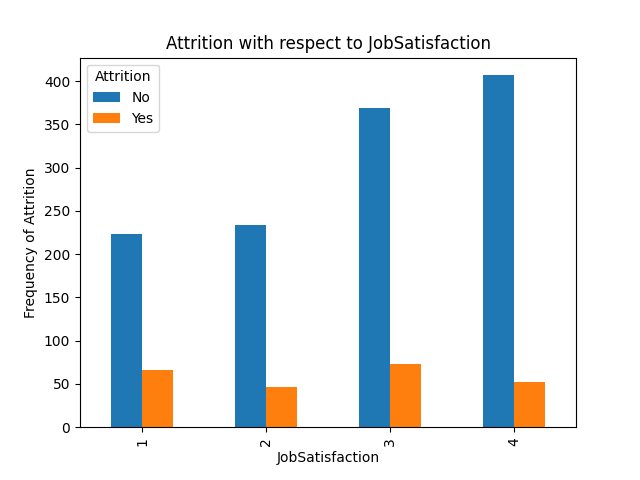

<IPython.core.display.Javascript object>


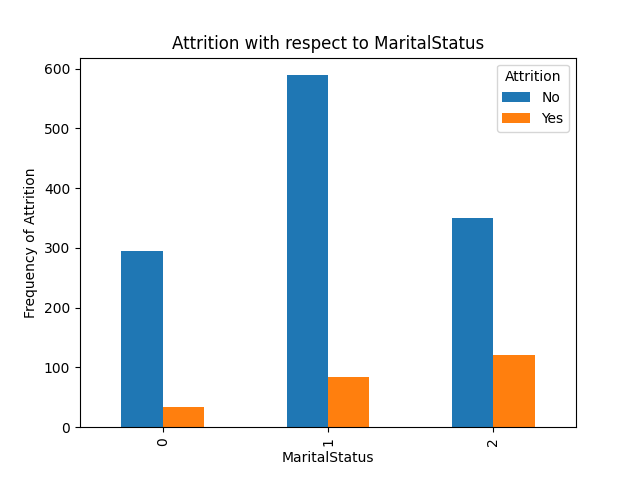

<IPython.core.display.Javascript object>


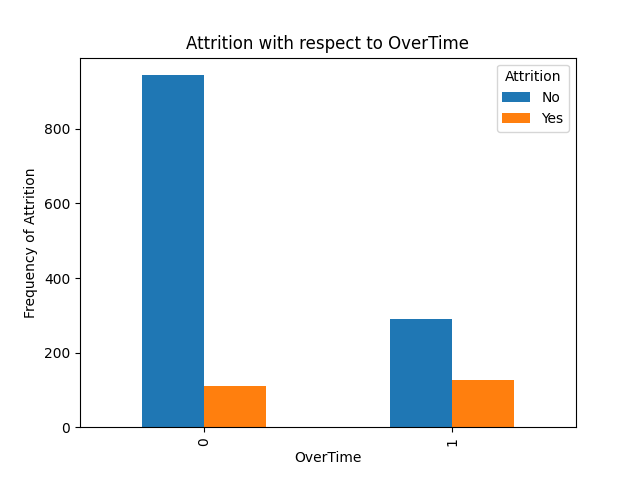

<IPython.core.display.Javascript object>


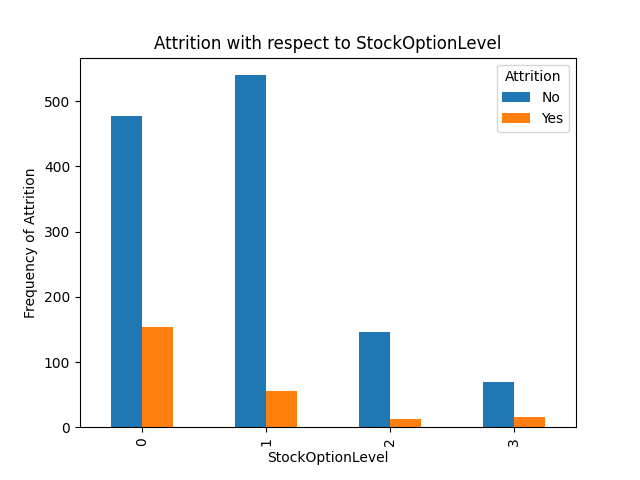

<IPython.core.display.Javascript object>


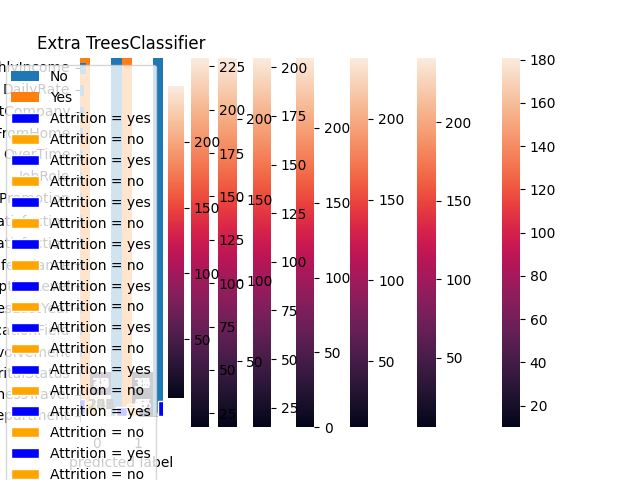

In [15]:
# Plots for Categorical data visualisation

dfplot = ['BusinessTravel', 'Department', 'EducationField', 'EnvironmentSatisfaction', 'JobInvolvement',
       'JobRole', 'JobSatisfaction', 'MaritalStatus', 'OverTime', 'StockOptionLevel', 'WorkLifeBalance']
d=df[dfplot]
for x in dfplot:
    pd.crosstab(d[x], df.Attrition).plot(kind='bar')
    plt.title('Attrition with respect to '+x)
    plt.xlabel(x)
    plt.ylabel('Frequency of Attrition')

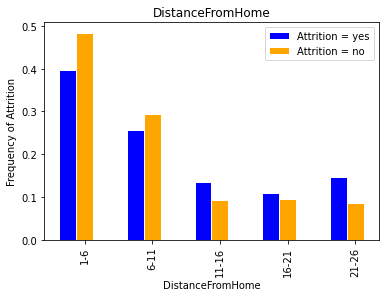

In [34]:
#function to generate frequency data for continuous value columns

dat1 = df.sort_values(by=['Attrition'])
for i in range(dat1.shape[0]):
    if dat1['Attrition'].values[i] == 'Yes':
        a = i
        break
        
dat2 = np.split(dat1,[a],axis=0)

dat_n = dat2[0]
dat_y = dat2[1]

def binn(data,B,n):            
    h = (np.amax(df[B].values)-np.amin(df[B].values))//n
    L1 = []
    L = []
    for j in range(n):
        c = 0
        a = str(np.amin(df[B].values)+j*h)+'-'+str(np.amin(df[B].values)+(j+1)*h)
        L.append(a)     #contains Categories 
        for i in range(data.shape[0]):
            if np.amin(df[B].values) + j*h <= data[B].values[i] <= np.amin(df[B].values) + (j+1)*h:
                c = c + 1
        L1.append(c/data.shape[0])
    return L1,L

#function to make barplots for a given data

def barplot(A,B,C,D):   #A/B = yes/no data , C = Categories  :function to generate barplot
    barWidth = 0.25
    r1 = np.arange(len(C))
    r2 = [x + barWidth for x in r1]
    plt.bar(r1, A, color='b', width=barWidth, edgecolor='white', label='Attrition = yes')
    plt.bar(r2, B, color='orange', width=barWidth, edgecolor='white', label='Attrition = no')
    plt.xticks([r + barWidth for r in range(len(W))], C)
    plt.xlabel(str(D))
    plt.ylabel('Frequency of Attrition')
    plt.title(D)
    plt.legend()
    plt.xticks( rotation='vertical')
    plt.show()
    
categ = 'DistanceFromHome'

W,L = binn(dat_y,categ,5)	
W1,L1 = binn(dat_n,categ,5)

barplot(W,W1,L,categ)

#People who live further away from their work show higher proportion of leavers compared to their counterparts

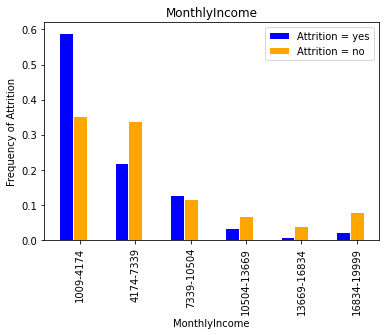

In [35]:
categ = 'MonthlyIncome'

W,L = binn(dat_y,categ,6)	
W1,L1 = binn(dat_n,categ,6)

barplot(W,W1,L,categ)



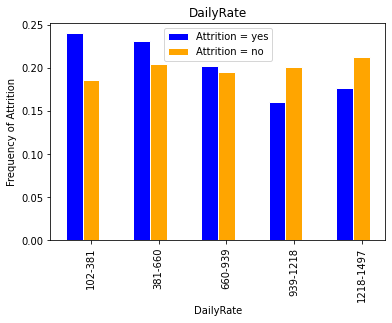

In [36]:
categ = 'DailyRate'

W,L = binn(dat_y,categ,5)	
W1,L1 = binn(dat_n,categ,5)

barplot(W,W1,L,categ)

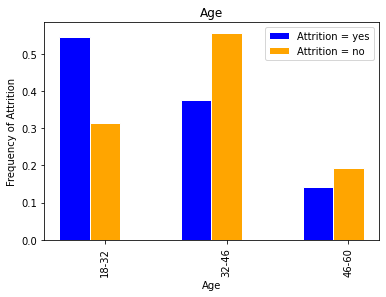

In [37]:
categ = 'Age'

W,L = binn(dat_y,categ,3)	
W1,L1 = binn(dat_n,categ,3)

barplot(W,W1,L,categ)

#Younger people seem to leave the company more often.

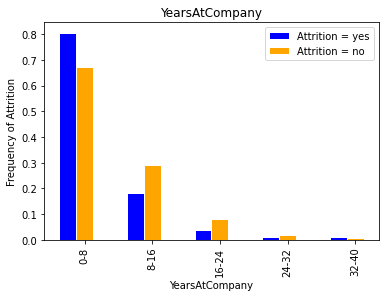

In [38]:
categ = 'YearsAtCompany'

W,L = binn(dat_y,categ,5)
W1,L1 = binn(dat_n,categ,5)

barplot(W,W1,L,categ)

#It seems that more is the number of years person has worked at the company, lesser is the attrition rate.

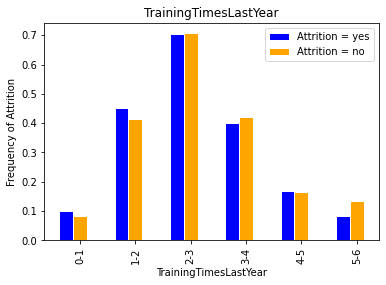

In [39]:
categ = 'TrainingTimesLastYear'

W,L = binn(dat_y,categ,6)
W1,L1 = binn(dat_n,categ,6)

barplot(W,W1,L,categ)

In [28]:

#After removing one of the strongly correlated variables, we get the following dataframe

df2 = df[['BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'EducationField',
          'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
          'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear','WorkLifeBalance', 
          'YearsAtCompany','YearsSinceLastPromotion']] #new dataframe with the selected attributes relevant for employee attrition 

dftitle=['BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'EducationField',
          'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
          'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear', 'WorkLifeBalance',
         'YearsAtCompany','YearsSinceLastPromotion']
df['Attrition'] =df['Attrition'].astype('category').cat.codes   #coverting yes and no attrition data to 0' and 1's

target = df['Attrition'].copy()    

names = []
models = []
models.append(('Logistic Regression', LogisticRegression(solver='liblinear' , class_weight='balanced')))
models.append(('Random Forest', RandomForestClassifier(n_estimators=40 )))
models.append(('KNN', KNeighborsClassifier()))
models.append(('SVM', SVC(gamma='auto' )))
models.append(('Decision Tree Classifier', DecisionTreeClassifier( )))
models.append(('Gradient Boost', GradientBoostingClassifier(learning_rate=0.1 )))
models.append(('Naive Bayes', GaussianNB()))
models.append(('Extra TreesClassifier', ExtraTreesClassifier()))

col = ['Algorithm', 'Accuracy', 'Precision', 'F1_score', 'ROC_AUC']
df_results = pd.DataFrame(columns=col)
i = 0

#80-20 splitting where 80% Data is for Training the Model and 20% Data is for Validation and Performance Analysis
X_train, X_test, y_train, y_test = train_test_split(df2,target,test_size=0.20, stratify=target)

res = {}
clf = RandomForestClassifier(n_estimators=10000, )
clf.fit(X_train, y_train)
for name, model in models:
    kfold = model_selection.KFold(n_splits=10 )
    acc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
    prec_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='precision')    
    f1_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='f1_weighted')
    roc_results = model_selection.cross_val_score(model, X_train, y_train, cv=kfold, scoring='roc_auc')
    
    model.fit(X_train,y_train)           #Training the model
    y_pred = model.predict(X_test)
    A = confusion_matrix(y_test, y_pred)               #plotting the confusion matrix
    ax = sns.heatmap(A,annot=True, fmt="d")
    ax.set_xticklabels(ax.get_xticklabels(),rotation=0,horizontalalignment='right')
    plt.title(str(name))
    plt.xlabel('predicted label')
    plt.ylabel('actual label')
    plt.show()
    
    names.append(name)
    df_results.loc[i] = [name, round(np.mean(acc_results), 7), round(np.mean(prec_results), 7),
                         round(np.mean(f1_results), 7), round(np.mean(roc_results), 7),]    
    i += 1
L1 = []
L1a = []
for feature in zip(dftitle, clf.feature_importances_): #Calculating the importances of each feature for RandomForestClassifier model
    L1.append(feature[0])
    L1a.append(feature[1])
feature = pd.DataFrame(list(zip(L1,L1a)),columns =['Feature','Value'])
feature = feature.sort_values(by=['Value'],ascending=False)


In [29]:
#Comparision of the different models
df_results    


,Algorithm,Accuracy,Precision,F1_score,ROC_AUC
0,Logistic Regression,0.731313,0.343999,0.762536,0.795025
1,Random Forest,0.857989,0.674444,0.819829,0.808950
2,KNN,0.819731,0.352143,0.775103,0.583114
3,SVM,0.838433,0.000000,0.764948,0.507711
4,Decision Tree Classifier,0.785644,0.333508,0.785489,0.609029
5,Gradient Boost,0.857193,0.627244,0.833104,0.806493
6,Naive Bayes,0.852050,0.588510,0.838959,0.782151
7,Extra TreesClassifier,0.852890,0.702251,0.820511,0.798752


<AxesSubplot:>

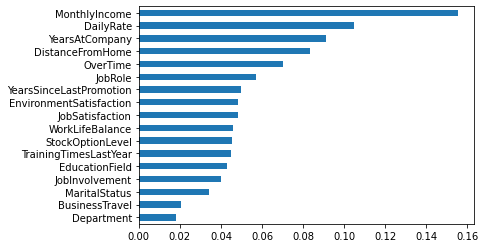

In [40]:
feat_importances = pd.Series(clf.feature_importances_, index=df2.columns) 
feat_importances = feat_importances.nsmallest(20)
feat_importances.plot(kind='barh')

#According to RandomForestClassifier model, it seems like monthly income contributes the most in Attrition of employees.

In [41]:
#Hyperparameter tuning for logistic regression

param_grid = {'C': np.arange(1e-03, 2, 0.01)} # hyper-parameter list to fine-tune
log_gs = GridSearchCV(LogisticRegression(solver='liblinear', class_weight="balanced", random_state=0),
                      return_train_score=True,
                      param_grid=param_grid,
                      scoring='roc_auc',
                      cv=10)

log_grid = log_gs.fit(X_train, y_train)
log_opt = log_grid.best_estimator_
results = log_gs.cv_results_


print("best params: " + str(log_gs.best_estimator_))
print("best params: " + str(log_gs.best_params_))
print('best score:', log_gs.best_score_)


TypeError: __init__() got an unexpected keyword argument 'iid'

In [ ]:
#Hyperparameter tuning for random forest classifier

rf_classifier = RandomForestClassifier(class_weight = "balanced",
                                       random_state=7)
param_grid = {'n_estimators': [50, 75, 100, 125, 150, 175],
              'min_samples_split':[2,4,6,8,10],
              'min_samples_leaf': [1, 2, 3, 4],
              'max_depth': [5, 10, 15, 20, 25]}

grid_obj = GridSearchCV(rf_classifier,
                        iid=True,
                        return_train_score=True,
                        param_grid=param_grid,
                        scoring='roc_auc',
                        cv=10)

grid_fit = grid_obj.fit(X_train, y_train)
rf_opt = grid_fit.best_estimator_


print("best params: " + str(grid_obj.best_estimator_))
print("best params: " + str(grid_obj.best_params_))
print('best score:', grid_obj.best_score_)

#The random forest classifier works quite well even with the default parameters with an accuracy of 0.85.
#Still, we tried to improve by tuning hyper parameters of Random Forest classifier. 
#Also, it doesn’t over fit easily because of its randomness feature.

In [ ]:
#checking the LogisticRegression model accuracy after hyperparameter tuning

logistic_regression = LogisticRegression(C=1.8709999999999996, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=0, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
kfold = model_selection.KFold(n_splits=10, random_state=0)
acc_results = model_selection.cross_val_score(logistic_regression, X_train, y_train, cv=kfold, scoring='accuracy')
print(np.mean(acc_results))

In [ ]:
#checking the RandomForestClassifier model accuracy after hyperparameter tuning

rf_clf = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=7, verbose=0, warm_start=False)
kfold = model_selection.KFold(n_splits=10, random_state=0)
acc_results = model_selection.cross_val_score(rf_clf, X_train, y_train, cv=kfold, scoring='accuracy')
print(np.mean(acc_results))

In [32]:
#IMPORT FEATURE for the trained RandomForestClassifier model

df2 = df[['BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'EducationField',
          'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
          'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear',
          'WorkLifeBalance', 'YearsAtCompany', 'YearsSinceLastPromotion'0]] 

rf1 = RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=7, verbose=0, warm_start=False)
X1_train = df2
y1_train = df['Attrition']
rf1.fit(X1_train,y1_train)
rf1

RandomForestClassifier(bootstrap=True, class_weight='balanced',
                       criterion='gini', max_depth=10, max_features='auto',
                       max_leaf_nodes=None, min_impurity_decrease=0.0,
                       min_impurity_split=None, min_samples_leaf=4,
                       min_samples_split=10, min_weight_fraction_leaf=0.0,
                       n_estimators=50, n_jobs=None, oob_score=False,
                       random_state=7, verbose=0, warm_start=False)

In [45]:
def randomforest():        #this function can now be used to predict employee attrition for any input data file effectively
    datafile = input()
    df=pd.read_csv(datafile)
    df.drop(['Attrition'],axis=1)
    for col_name in df.columns:
        if(df[col_name].dtype == 'object'):
            df[col_name]= df[col_name].astype('category')
            df[col_name] = df[col_name].cat.codes
    df2 = df[['BusinessTravel', 'DailyRate', 'Department', 'DistanceFromHome', 'EducationField',
          'EnvironmentSatisfaction', 'JobInvolvement', 'JobRole', 'JobSatisfaction', 'MaritalStatus',
          'MonthlyIncome', 'OverTime', 'StockOptionLevel', 'TrainingTimesLastYear',
          'WorkLifeBalance', 'YearsAtCompany']]
    return(df2)
a = randomforest()
b = list(rf1[1].predict(a))

for i in range(len(b)):
    if b[i]==1.0:
        b[i]='YES'
    else:
        b[i]='NO'
        
print(len(b))
num=list(df['EmployeeNumber'])
newdf = pd.DataFrame(list(zip(num, b)), 
               columns =['EmployeeNumber', 'Attrition']) 
newdf  

#This is the result of the prediction using our RANDOMFORESTCLASSIFIER model specifying
#whether an employee will leave the company or not.

WA_Fn-UseC_-HR-Employee-Attrition.csv
1470


,EmployeeNumber,Attrition
0,1,NO
1,2,NO
2,4,YES
3,5,NO
4,7,YES
...,...,...
1465,2061,NO
1466,2062,NO
1467,2064,NO
1468,2065,NO
